In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
trial=pd.read_csv("usd_cad_final.csv")                                         
trial =trial [["FX_Rate","Timestamp"]]                               


returns=[]                                                                     #Creating an empty list for returns
for i in range(1,len(trial)):
    returns.append((trial.iloc[i,0]-trial.iloc[i-1,0])/trial.iloc[i-1,0])      #Calculating returns 

returns.insert(0,0)                                                            #Inserting null value for the first element
trial["returns"]=pd.Series(returns)                                            #Converting the list into a series
 


#Average of the returns:

i=0
j=360
store=len(trial)//360
average_returns=[]                                      #creating an empty list 
for i in range(store):
    average_returns.append(np.mean(trial.iloc[1:j,2]))  
    i+=360                                              
    j+=360

#Average of the prices

i=0
j=360
store=len(trial)//360
average_prices=[]
for i in range(store):
    average_prices.append(np.mean(trial.iloc[1:j,0]))
    i+=360
    j+=360

    
#Standard Deviation of the prices

i=0
j=360
store=len(trial)//360
stds_prices=[]
for i in range(store):
    stds_prices.append(np.std(trial.iloc[1:j,0]))
    i+=360
    j+=360


#Trading strategy: 
#3 consecutive positive returns trigger a buy on the thrid ticker
#3 consecutive negative returns trigger a sell on the thrid ticker
#If these conditions aren't met, do nothing

j=0
index=False
sell=0
buy=0                                                                                   #Starting loop from index 2 since we
final_list=[]                                                                           #need 3 values to determine
for i in range(2,len(average_returns)):                                                 #whether to buy or sell 
    if buy==0 and sell==0:                                                              #initial conditions set to 0 buy/sell 
        if average_returns[j+2]>0 and average_returns[j+1]>0 and average_returns[j]>0:    
            final_list.append("sell")
            j+=1
            index=True                                                                  #switching index to true if its a sell
            sell+=1                                                                     
        elif average_returns[j+2]<0 and average_returns[j+1]<0 and average_returns[j]<0:
            final_list.append("buy")
            j+=1
            buy+=1
        else:
            final_list.append("do nothing")
            j+=1
            
    elif index==True:
        if average_returns[j+2]<0 and average_returns[j+1]<0 and average_returns[j]<0:
            final_list.append("buy")
            j+=1
            index=False                                                                 
        else :
            final_list.append("do nothing")
            j+=1
    else :
        if average_returns[j+2]>0 and average_returns[j+1]>0 and average_returns[j]>0:
            final_list.append("sell")
            j+=1
            index=True
        else :
            final_list.append("do nothing")
            j+=1
            
final_list.insert(0,"do nothing")
final_list.insert(0,"do nothing")


#Creating a decisions list where a sell is positive and a buy is negative

decisions = []
for decision in final_list:
    if decision == 'sell':
        decisions.append(1)
    elif decision == 'buy':
        decisions.append(-1)
    else:
        decisions.append(0)


#Creating a unified dataframe for values

stats_outlook=pd.DataFrame()
stats_outlook["average_price"]=average_prices
stats_outlook["standard_deviation"]=stds_prices
stats_outlook["average_return"]=average_returns
stats_outlook["trading_decision"]=final_list
stats_outlook["decision_boolean"]=decisions
stats_outlook["gain_loss"]=decisions*stats_outlook['average_price']

#Calculating Profit

percent_profit = sum(stats_outlook["gain_loss"])/stats_outlook['average_price'][0]

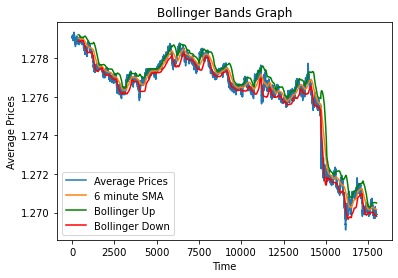

In [3]:
def get_sma(prices, rate):
    return prices.rolling(rate).mean()

def get_bollinger_bands(prices, rate=360):
    sma = get_sma(prices, rate)
    std = prices.rolling(rate).std()
    bollinger_up = sma + std * 1.25                              #Calculating upper band
    bollinger_down = sma - std * 1.25                            #Calculating lower band
    return bollinger_up, bollinger_down 

symbol = 'Bollinger Bands Graph'
closing_prices = trial['FX_Rate'] 

sma = get_sma(closing_prices,360) 
bollinger_up, bollinger_down = get_bollinger_bands(closing_prices)

# Plot the data
plt.title(symbol)
plt.xlabel('Time')
plt.ylabel('Average Prices')
plt.plot(closing_prices, label='Average Prices')
plt.plot(sma, label='6 minute SMA')
plt.plot(bollinger_up, label='Bollinger Up', c='g')
plt.plot(bollinger_down, label='Bollinger Down', c='r')
plt.legend()
plt.show()

In [4]:
malist=[]
stdlist=[]

for start in range(0, len(closing_prices)-360):
    malist.append(np.mean(closing_prices[start: start + 360]))
for start in range(0, len(closing_prices)-360):
    stdlist.append(np.std(closing_prices[start: start + 360]))

upper=[]
lower=[]

for i in range(len(malist)):
    urb = malist[i] + (stdlist[i] * 1.25)
    upper.append(urb)
for i in range(len(malist)):
    lrb = malist[i] - (stdlist[i] * 1.5)
    lower.append(lrb)
    
#Checking the number of trades that occured in the given interval

clicker=0
for i in range (len(stats_outlook)):
    if (final_list[i] == "do nothing"):
        clicker += 1

trades = len(stats_outlook)-clicker

#Checking the number of trades that occured outside the Bollinger Bands

xtrade=0

for i in range (len(stats_outlook)):
    if (final_list[i] == 'buy') and (average_prices[i]<lower[i]):
        xtrade += 1
        print(" Decision:",final_list[i],"\n","Price bought at:",average_prices[i],"\n","Lower Bollinger set at",lower[i])
    elif (final_list[i] == 'sell') and (average_prices[i]>upper[i]):
        xtrade +=1
        print(" Decision:",final_list[i],"\n","Price sold at:",average_prices[i],"\n","Upper Bollinger set at",upper[i])
    else:
        continue

 Decision: buy 
 Price bought at: 1.2785798123697012 
 Lower Bollinger set at 1.2788400584178528


In [5]:
stats_outlook["trading_decision"].value_counts()

do nothing    49
buy            1
Name: trading_decision, dtype: int64

In [6]:
print (" Total number of trades conducted:",trades,"\n","Total number of trades conducted outside the Bollinger Bands:",xtrade)

 Total number of trades conducted: 1 
 Total number of trades conducted outside the Bollinger Bands: 1


In [7]:
percent_profit

-0.999636202844397